In [198]:
# Imports
import csv
import matplotlib.pyplot as plt
import numpy as np
import os

from math import sqrt
from numpy import mean

from sklearn import svm
from sklearn.model_selection import train_test_split
from scipy.fft import fft

from keras.models import Sequential
from keras.layers import Dense, Dropout, Reshape, Conv1D, MaxPooling1D, GlobalAveragePooling1D

# Constants
MAX_LEN = 150

In [214]:
# Read training labels

with open('./data/train_labels.csv', newline='') as csv_file:
    reader = csv.reader(csv_file)

    # Skip the first line
    reader.__next__()

    # Read the labels
    train_labels = [(label[0], int(label[1]) - 1) for label in reader]


In [215]:
# Read training files

train_data = []

for label in train_labels:
    with open(f'./data/train/{label[0]}.csv', newline='') as csv_file:
        reader = csv.reader(csv_file)

        # Convert data to list of tuples and from str to float
        data = [tuple(map(float, (coord[0], coord[1], coord[2]))) for coord in reader]

        # Append data and label
        train_data.append(data)


# Make a copy for plotting purposes
train_data_plot = train_data.copy()

In [216]:
# Update train labels

train_labels = [label[1] for label in train_labels]

In [202]:
# Calculate magnitude of vectors

#train_data = [[sqrt(coord[0]**2 + coord[1]**2 + coord[2]**2) for coord in data] for data in train_data]

In [242]:
# Cut longer frequencies to the MAX_LEN, or fill shorter frequencies to the MAX_LEN with mean value

train_data = [data[:MAX_LEN] for data in train_data]
print(len(train_data[1]))
print([tuple([mean(train_data[1]) for _ in range(len(train_data[1][0]))])] * (MAX_LEN - len(train_data[1])))

# Check if the input is multidimensional or single dimensional
# if isinstance(train_data[0][0], tuple):
#     train_data = [data + [tuple([mean(data) for _ in range(len(train_data[0][0]))])] * (MAX_LEN - len(data)) for data in train_data]
# else:
#     train_data = [data + [mean(data)]*(MAX_LEN - len(data)) for data in train_data]


e:\Facultate\master1\practical-machine-learning\venv\lib\site-packages\numpy\core\_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


[]


In [204]:
# Fourier transform data
train_data_fft = [fft(data) for data in train_data]
train_data_fft = np.abs(train_data_fft)

In [205]:
# Train test split

X_train, X_test, y_train, y_test = train_test_split(train_data_fft, train_labels, test_size=0.2, random_state=42)

X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

SVM Model

In [206]:
# Define svm model and train

classifier = svm.SVC()
_ = classifier.fit(X_train, y_train)

In [207]:
# Calculate accuracy

score = classifier.score(X_test, y_test)
score

0.35555555555555557

NN Model

In [211]:
# Define model

model = Sequential()
model.add(Reshape((50, num_sensors), input_shape=(input_shape,)))
model.add(Conv1D(100, 10, activation='relu', input_shape=(3, num_sensors)))
model.add(Conv1D(100, 10, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(160, 10, activation='relu'))
model.add(Conv1D(160, 10, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))
model.add(Dense(20, activation='softmax'))

In [212]:
# Compile model

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [213]:
# Train model

model.fit(X_train, y_train, epochs=25, verbose=2, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/25
450/450 - 8s - loss: 14.0568 - accuracy: 0.0878 - val_loss: 2.7457 - val_accuracy: 0.1300 - 8s/epoch - 17ms/step
Epoch 2/25


KeyboardInterrupt: 

Create Predictions

In [ ]:
# Change to true if using NN instead of SVM

USING_SVM = False

In [ ]:
# Make prediction and save it

X_validation = []
csv_names = []

for csv_file_path in os.scandir('./data/test/'):
    csv_names.append(os.path.basename(csv_file_path).split('.')[0])
    
    with open(csv_file_path, newline='') as csv_file:
        reader = csv.reader(csv_file)
        X_validation.append([tuple(map(float, (coord[0], coord[1], coord[2]))) for coord in reader])


# Apply data transformation
X_validation = [[sqrt(coord[0]**2 + coord[1]**2 + coord[2]**2) for coord in data] for data in X_validation]
X_validation = [data[:MAX_LEN] for data in X_validation]
X_validation = [data + [mean(data)]*(MAX_LEN - len(data)) for data in X_validation]

# Fourier transform data
X_validation_fft = [fft(data) for data in X_validation]
X_validation_fft = np.abs(X_validation_fft)

# Make prediction
predictions = []

if USING_SVM:
    for validate in X_validation:
        predictions.append(classifier.predict([validate])[0])
else:
    predictions_raw = model.predict(X_validation_fft)
    for prediction_raw in predictions_raw:
        predictions.append(np.argmax(prediction_raw) + 1)

# Combine for writing
predictions = zip(csv_names, predictions)

# Write prediction
_, _, files = next(os.walk('./data/submissions/'))
file_count = len(files)

with open(f'./data/submissions/{str(file_count).rjust(5, "0")}.csv', 'w', newline='') as submission_csv:
    writer = csv.writer(submission_csv)

    writer.writerow(('id', 'class'))
    writer.writerows(predictions)

    print(f'Saved submission with name {submission_csv.name}')

157/157 [==============================] - 0s 1ms/step
Saved submission with name ./data/submissions/00007.csv


### Plot a CSV

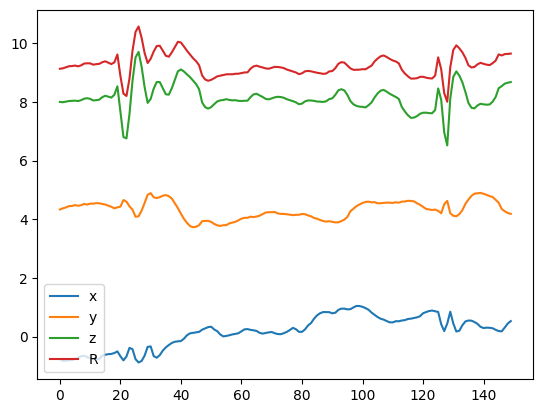

In [ ]:
from math import sqrt

csv_number = 0
plot_data = train_data_plot[csv_number]

length = list(range(len(plot_data)))

plt.plot(length, [coord[0] for coord in plot_data], label='x')
plt.plot(length, [coord[1] for coord in plot_data], label='y')
plt.plot(length, [coord[2] for coord in plot_data], label='z')
plt.plot(length, [sqrt(coord[0]**2 + coord[1]**2 + coord[2]**2) for coord in plot_data], label='R')

plt.legend()
plt.show()